In [1]:
# --- PyTorch
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
# --- NetworkX
import networkx as nx
# --- RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# --- Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# --- Modules from local files
from GNN.GNN_mol import GNN
from dataset import XASDataset_mol
from utils.model import train_model, val_test
from utils.utils import plot_learning_curve

#### Import dataset

In [4]:
# --- Path raw directory containing the data
path = "./"
# --- Load and create the dataset
dataset = XASDataset_mol(path)


In [3]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

torch.save(dataset, './datasets/atom_cir_dataset_long.pt')

XASDataset_mol(91)
------------
Number of graphs: 91
Number of features: 5
Number of classes: 0

Data(x=[59, 5], edge_index=[2, 158], edge_attr=[158, 3], spectrum=[200], pos=[59, 3], z=[59], idx=[1], smiles='c12[c:1]3[c:2]4[c:3]([c:4]([H:59])[c:5]1[H:60])[c:38]([H:76])[c:39]1[c:40]5[c:9]4[c:8]4[c:7]6[c:6]3[c:24]3[c:23]([c:22]2[H:75])[c:31]([H:63])[c:32]([H:64])[c:33]2[c:25]3[c:26]3[c:10]6[c:11]6[c:12]7[c:13]4[c:42]4[c:41]5[c:49]([c:48]([H:70])[c:47]1[H:69])[c:50]([H:71])[c:51]1[c:43]4[c:44]4[c:17]7[c:16]5[c:15]7[c:14]6[c:28]6[c:27]3[C:35]3([C:34]2([H:65])[O:58]3)[C:36]([H:66])=[C:37]([H:67])[c:29]6[c:30]([H:62])[c:18]7[c:19]([C:54](=[O:56])[O:57][H:74])[c:20]([H:61])[c:21]5[c:46]([H:68])[c:45]4[C:53]2([H:73])[C:52]1([H:72])[O:55]2')
------------
Number of nodes: 59
Number of edges: 158
Average node degree: 2.68
Has isolated nodes: False
Has self loops: False
Is undirected: True


#### View data

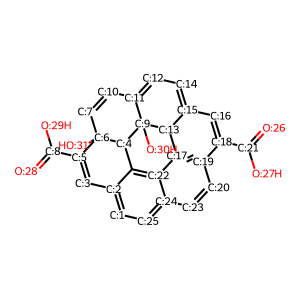

In [4]:
mol = Chem.MolFromSmiles(data.smiles)
mol

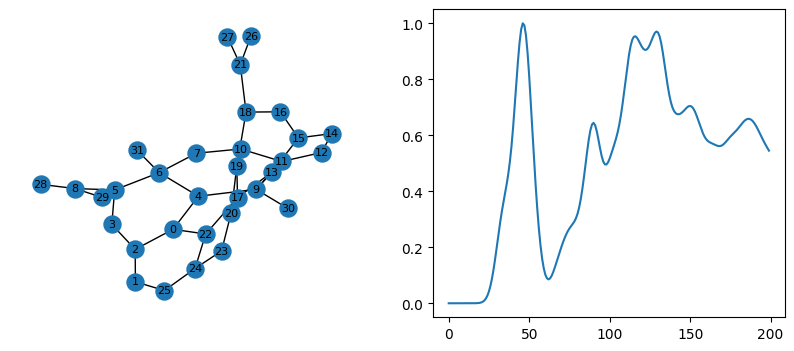

In [5]:
# --- Create subplot for plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)
nx.draw(mol_graph, ax=ax1, with_labels=True, node_size=150, font_size=8)

# --- Show molecule spectrum
ax2.plot(data.spectrum)
plt.show()

#### Split up dataset

In [6]:
# --- Split data into test, validation and test
train_dataset = dataset[0:238]
val_dataset = dataset[239:268]
test_dataset = dataset[269:]

# --- Pass into dataloader
train_loader = DataLoader(train_dataset, batch_size=238, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=29, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=48, shuffle=False)

print(f'Length of training data loader: {len(train_loader.dataset)}, with a total of {len(train_loader)} datassets')
print(f'Length of validation data loader: {len(val_loader.dataset)}, with a total of {len(val_loader)} datasets')
print(f'Length of testing data loader: {len(test_loader.dataset)}, with a total of {len(test_loader)} datasets')

torch.save(test_dataset, './datasets/mol_test_dataset_long.pt')

Length of training data loader: 238, with a total of 1 datassets
Length of validation data loader: 29, with a total of 1 datasets
Length of testing data loader: 48, with a total of 1 datasets


#### Set neural network properties

In [7]:
num_tasks = 200
num_layers = 3
emb_dim = dataset.num_features
in_channels = [int(emb_dim), 64, 128]
out_channels = [64, 128, 256]
gnn_type = "sage"
heads = 1
drop_ratio = 0.5
graph_pooling = "mean"

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
print(model)
print('----')
print(f'Training will be performed on: {device}')

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): SAGEConv(15, 64, aggr=mean)
      (1): SAGEConv(64, 128, aggr=mean)
      (2): SAGEConv(128, 256, aggr=mean)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=256, out_features=200, bias=True)
)
----
Training will be performed on: cpu


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)

#### Run neural network training

In [10]:
num_epochs = 300
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    loss = train_model(model, train_loader, optimizer, device)

    val_error = val_test(model, val_loader, device)

    scheduler.step(val_error)

    train_losses.append(loss)

    val_losses.append(val_error)

    current_lr = optimizer.param_groups[0]["lr"]

    if epoch % 25 == 0:
        print(f"Epoch: {epoch:03d}, LR: {current_lr:.3f}, TrainLoss: {loss:.5f}, ValLoss: {val_error:.5f}")

print('--------------')
print(f'Final training loss value of: {loss:.5f} and validation loss of: {val_error:.5f}')

Epoch: 000, LR: 0.010, TrainLoss: 0.26075, ValLoss: 0.28781
Epoch: 025, LR: 0.010, TrainLoss: 0.02245, ValLoss: 0.02652
Epoch: 050, LR: 0.010, TrainLoss: 0.01213, ValLoss: 0.01176
Epoch: 075, LR: 0.010, TrainLoss: 0.00952, ValLoss: 0.01113
Epoch: 100, LR: 0.010, TrainLoss: 0.00856, ValLoss: 0.01038
Epoch: 125, LR: 0.010, TrainLoss: 0.00822, ValLoss: 0.01070
Epoch: 150, LR: 0.010, TrainLoss: 0.00812, ValLoss: 0.01033
Epoch: 175, LR: 0.010, TrainLoss: 0.00770, ValLoss: 0.00990
Epoch: 200, LR: 0.010, TrainLoss: 0.00771, ValLoss: 0.00989
Epoch: 225, LR: 0.010, TrainLoss: 0.00729, ValLoss: 0.01000
Epoch: 250, LR: 0.010, TrainLoss: 0.00701, ValLoss: 0.01001
Epoch: 275, LR: 0.005, TrainLoss: 0.00692, ValLoss: 0.01014
--------------
Final training loss value of: 0.00699 and validation loss of: 0.00990


In [11]:
model_name = 'model_gnn_mol_sage.pt'
torch.save(model.state_dict(), "ML_models/" + model_name)

#### View loss

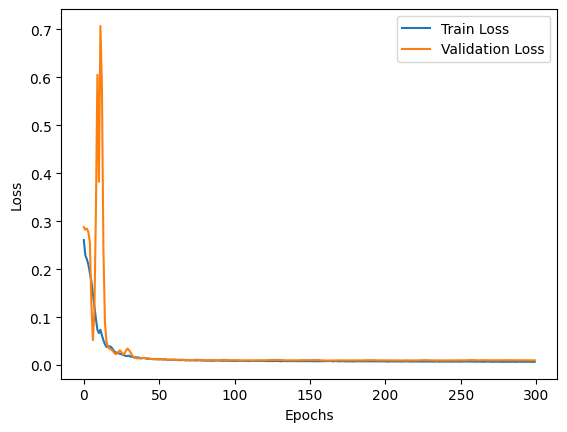

In [12]:
plot_learning_curve(num_epochs, train_losses, val_losses)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE

trans = transform(n_components=3, perplexity=30, early_exaggeration=12, n_iter=1000)
x_reduced = trans.fit_transform(embedding.cpu().detach().numpy())
x_reduced.shape

(7118, 3)

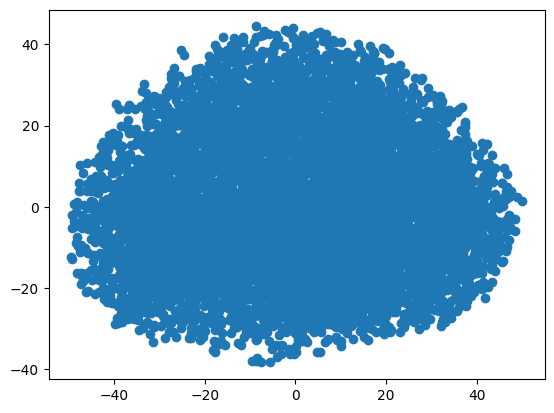

In [ ]:
plt.scatter(x_reduced[:,0], x_reduced[:,1])
plt.show()

In [ ]:
pca = PCA(n_components=2)
pca_fit = pca.fit(embedding.cpu().detach().numpy())

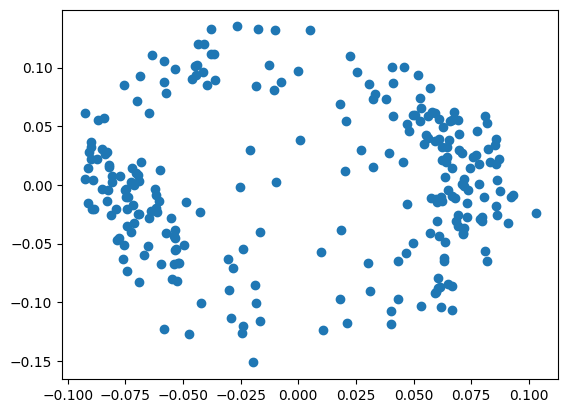

In [ ]:
plt.scatter(pca_fit.components_[0], pca_fit.components_[1])
plt.show()